# ML4N - Group Project 7
# Analysing Adversarial Attacks on Tabular Data Classifiers

In [90]:
# import needed python libraries
# Per ora ci ho messo quanta più roba potesse servire, in seguito rimuoviamo ciò che non serve 

import pandas as pd
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf

from matplotlib.ticker import StrMethodFormatter
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod


# 1 Data exploration and preprocessing

### 1.1 Dataset Acquisition ###

In [91]:
#### List of Attributes for dataset acquired from german.doc
#### good/bad is the label 1 means good customer while 2 means bad
attributes = ["Status_account", "Duration", "Credit_history","Purpose",
             "Credit_amount","Savings_account/bonds","Employment_since","Install_rate",
              "Personal_status_sex","debtors_guarantors","Present_residence_since",
              "Property","Age","Other_install_plans","Housing","No_credits","Job",
              "No_people_liable","Telephone","foreign_worker","good/bad"] 

#### Acquiring dataset from german.data file
df = pd.read_csv("german.data", sep=' ', names = attributes)
df


,Status_account,Duration,Credit_history,Purpose,Credit_amount,Savings_account/bonds,Employment_since,Install_rate,Personal_status_sex,debtors_guarantors,...,Property,Age,Other_install_plans,Housing,No_credits,Job,No_people_liable,Telephone,foreign_worker,good/bad
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,...,A121,31,A143,A152,1,A172,1,A191,A201,1
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,...,A122,40,A143,A152,1,A174,1,A192,A201,1
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,...,A123,38,A143,A152,1,A173,1,A191,A201,1
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,...,A124,23,A143,A153,1,A173,1,A192,A201,2


### 1.2 Data Preprocessing ###

In [92]:
#### Qualitative attributes that do not require encoding 
to_remove = ["Duration","Credit_amount","Install_rate","Present_residence_since",
             "Age","No_credits","No_people_liable","good/bad"] 

#### Creating the list with the categorical attributes to be encoded
to_be_encoded = attributes.copy()
for el in to_remove:
    to_be_encoded.remove(el)

#### Normalizing only the numerical values before one hot encoding for later uses 
scaler2 = MinMaxScaler()
df_normalized_with_categorical = df.copy()
df_normalized_with_categorical[to_remove] = scaler2.fit_transform(df_normalized_with_categorical[to_remove])
#display(df_normalized_with_categorical)

#### Using One Hot Encoding to transform categorical attributes into qualitative ones
df_encoded = pd.get_dummies(df, columns=to_be_encoded, dtype = int)
display(df_encoded)

#### Setting bad to 0 and good to 1
mask_bad = df_encoded['good/bad'] == 2
df_encoded["good/bad"] = np.where(mask_bad, 0, 1)

#### Normalization between [0,1] and split into 80% training and 20% test 
scaler = MinMaxScaler()


#### Creation of the pandas dataframe of the normalized values
array_df_encoded2 = scaler.fit_transform(df_encoded)
df_normalized = pd.DataFrame(array_df_encoded2, columns=df_encoded.columns)

df_normalized

,Duration,Credit_amount,Install_rate,Present_residence_since,Age,No_credits,No_people_liable,good/bad,Status_account_A11,Status_account_A12,...,Housing_A152,Housing_A153,Job_A171,Job_A172,Job_A173,Job_A174,Telephone_A191,Telephone_A192,foreign_worker_A201,foreign_worker_A202
0,6,1169,4,4,67,2,1,1,1,0,...,1,0,0,0,1,0,0,1,1,0
1,48,5951,2,2,22,1,1,2,0,1,...,1,0,0,0,1,0,1,0,1,0
2,12,2096,2,3,49,1,2,1,0,0,...,1,0,0,1,0,0,1,0,1,0
3,42,7882,2,4,45,1,2,1,1,0,...,0,1,0,0,1,0,1,0,1,0
4,24,4870,3,4,53,2,2,2,1,0,...,0,1,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,1736,3,4,31,1,1,1,0,0,...,1,0,0,1,0,0,1,0,1,0
996,30,3857,4,4,40,1,1,1,1,0,...,1,0,0,0,0,1,0,1,1,0
997,12,804,4,4,38,1,1,1,0,0,...,1,0,0,0,1,0,1,0,1,0
998,45,1845,4,4,23,1,1,2,1,0,...,0,1,0,0,1,0,0,1,1,0


,Duration,Credit_amount,Install_rate,Present_residence_since,Age,No_credits,No_people_liable,good/bad,Status_account_A11,Status_account_A12,...,Housing_A152,Housing_A153,Job_A171,Job_A172,Job_A173,Job_A174,Telephone_A191,Telephone_A192,foreign_worker_A201,foreign_worker_A202
0,0.029412,0.050567,1.000000,1.000000,0.857143,0.333333,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,0.647059,0.313690,0.333333,0.333333,0.053571,0.000000,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.117647,0.101574,0.333333,0.666667,0.535714,0.000000,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.558824,0.419941,0.333333,1.000000,0.464286,0.000000,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.294118,0.254209,0.666667,1.000000,0.607143,0.333333,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.117647,0.081765,0.666667,1.000000,0.214286,0.000000,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
996,0.382353,0.198470,1.000000,1.000000,0.375000,0.000000,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
997,0.117647,0.030483,1.000000,1.000000,0.339286,0.000000,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
998,0.602941,0.087763,1.000000,1.000000,0.071429,0.000000,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


### 1.3 Exploratory Data Analysis ###

# 2 Unsupervised exploration and clustering #

### 2.1 Dimensionality reduction for data visualization ###

In [94]:
#### Splitting the data into sets 
columns_no_label = df_normalized_no_label.columns
X, X_test, y, y_test = train_test_split(
    df_normalized_no_label[columns_no_label], # X
    df_normalized['good/bad'], # y
    stratify = df_normalized['good/bad'], # stratify the dataset based on class labels
    train_size = 0.8, # percentage of training set
    random_state = 15 
)

<function matplotlib.pyplot.show(close=None, block=None)>

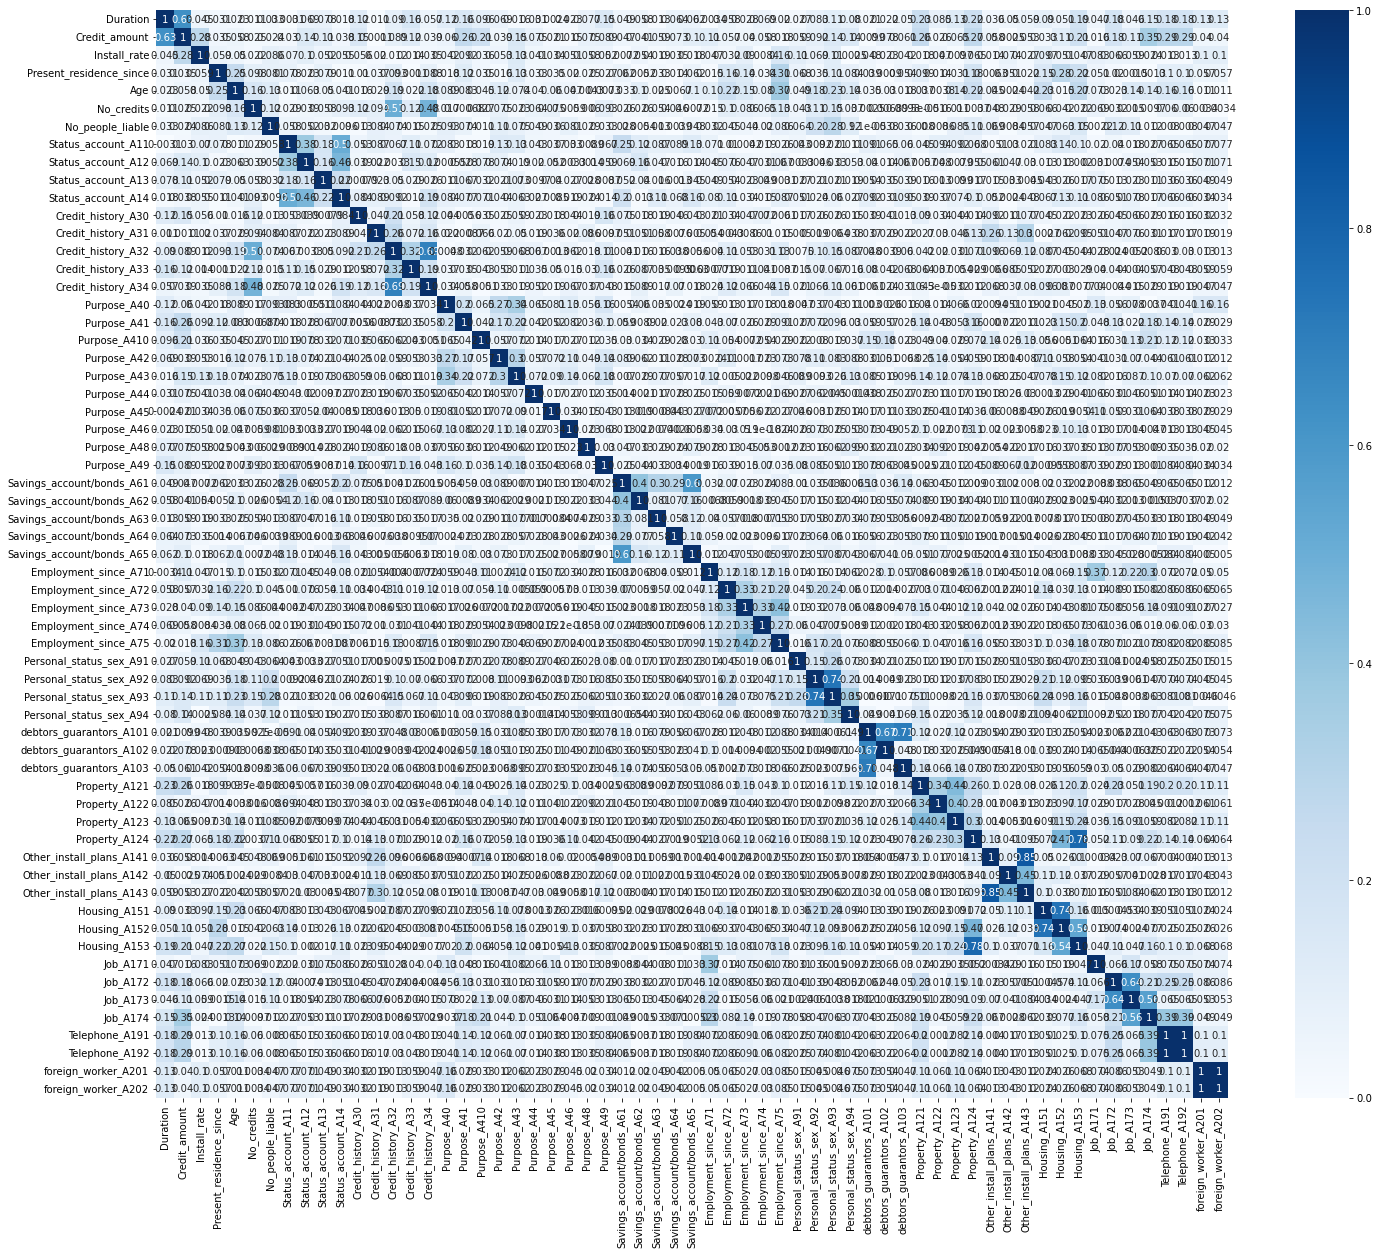

In [95]:
#### Apply dimensionality reduction techniques: t-Distributed Stochastic Neighbor Embedding (t-SNE)
#### and Principal Component Analysis (PCA) to reduce and visualize the data.

#### I compute the correlation between the features to see if there are any correlated features
correlation_analysis = X.corr().abs()

plt.figure(figsize = (24,20))
sns.heatmap(correlation_analysis, cmap="Blues", annot=True)
plt.show

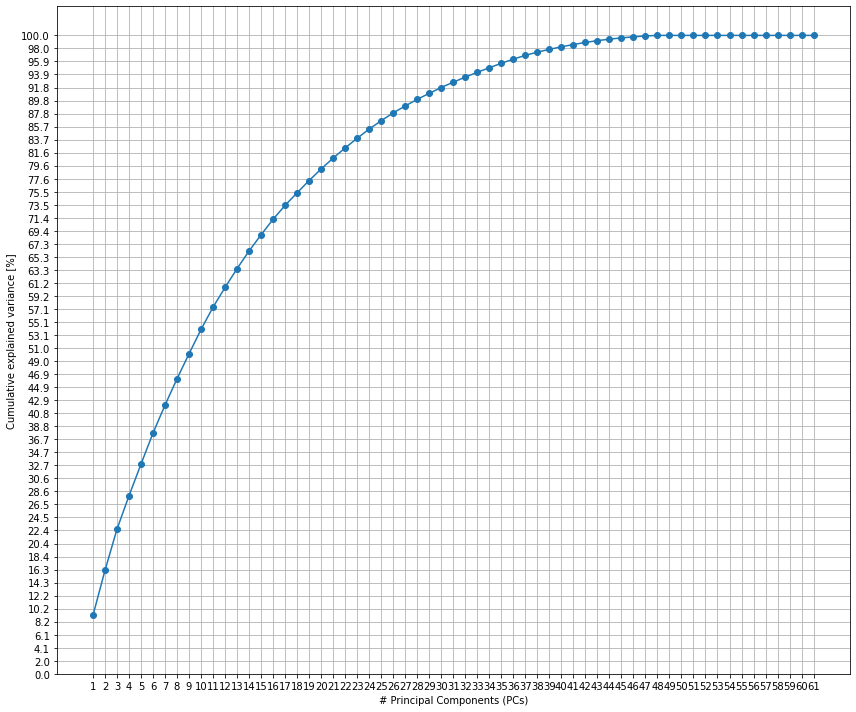

0 : 9.152967808004323
1 : 16.208713217323112
2 : 22.661977734225005
3 : 27.89231330751365
4 : 32.85220892324281
5 : 37.71869568312484
6 : 42.09680948920679
7 : 46.22164517918896
8 : 50.139328421366045
9 : 53.94771468880012
10 : 57.442312855325504
11 : 60.518524706255796
12 : 63.47825136446764
13 : 66.23488249568497
14 : 68.77713902397937
15 : 71.20402981871509
16 : 73.38331486266652
17 : 75.35208973135626
18 : 77.26835824047166
19 : 79.08379697782553
20 : 80.78435662395216
21 : 82.37520953935288
22 : 83.88769471587815
23 : 85.32898286721495
24 : 86.64474684460215
25 : 87.85674868785401
26 : 88.95082155986596
27 : 89.98438215007283
28 : 90.92654915636852
29 : 91.83844761082337
30 : 92.67661814827395
31 : 93.46866554764509
32 : 94.21561350907523
33 : 94.93135423048435
34 : 95.62937171497326
35 : 96.28548506874002
36 : 96.870167700393
37 : 97.39012232536624
38 : 97.80700111757767
39 : 98.2171335114673
40 : 98.56838537879544
41 : 98.8978861892779
42 : 99.18156657153376
43 : 99.406014515874

In [96]:
#### PCA to check the variances

pca = PCA(random_state=15)
pca.fit(X)

#### Here i compute the variability of the dataset, while the varaible number keeps increasing, 
#### until reaching all the number
explained_variance = pca.explained_variance_ratio_

#### This allows to represent the sum for each step (remember 61 features)
cum_exp_var = np.cumsum(explained_variance)

#### Representing it in percentage
perc_cum_exp_var = cum_exp_var * 100

#### Make the plot of cumulative explained variance w.r.t. number of components
plt.figure(figsize=(12, 10))
plt.plot(perc_cum_exp_var, marker='o')
plt.xlabel('# Principal Components (PCs)')
plt.ylabel('Cumulative explained variance [%]')
plt.xticks([i for i in range(61)], [i for i in range(1,62)])
plt.yticks(np.linspace(0,100, 50))
plt.grid()
plt.tight_layout()
plt.show()

for i in range (len(perc_cum_exp_var)):
    print(i, ":", perc_cum_exp_var[i])



In [97]:
#### I Apply t-SNE for dimensionality reduction
perplexities = [5, 10, 20, 30, 50]
learning_rate = np.linspace(10, 1000, 5)

plt.figure(figsize=(15, 10))

for i, perplexity in enumerate(perplexities, 1):
    for lr in learning_rate:
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, learning_rate = lr)
        X_tsne = tsne.fit_transform(df_normalized_no_label[columns_no_label])
        if (perplexity == 5 and lr == 10):
            transformed_df_t_sne = pd.DataFrame(X_tsne, columns = ['C1', 'C2'])

        # scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
        # plt.title(f't-SNE Visualization (Perplexity={perplexity}, Learning Rate={lr})')
        # plt.show()

transformed_df_t_sne

,C1,C2
0,9.387000,45.106659
1,-21.120193,-25.617643
2,-48.730602,24.894571
3,-40.195545,8.426905
4,43.167259,44.267723
...,...,...
995,-20.166744,-7.803782
996,47.526978,4.838389
997,-8.807094,29.463387
998,35.353855,29.948048


<Figure size 1080x720 with 0 Axes>

In [99]:
#### I choose 47 components because I'll be able to describe 100% of the dataset
pca = PCA(n_components = 47)
pca.fit(X)

X = pca.transform(X)
X_test = pca.transform(X_test)

<function matplotlib.pyplot.show(close=None, block=None)>

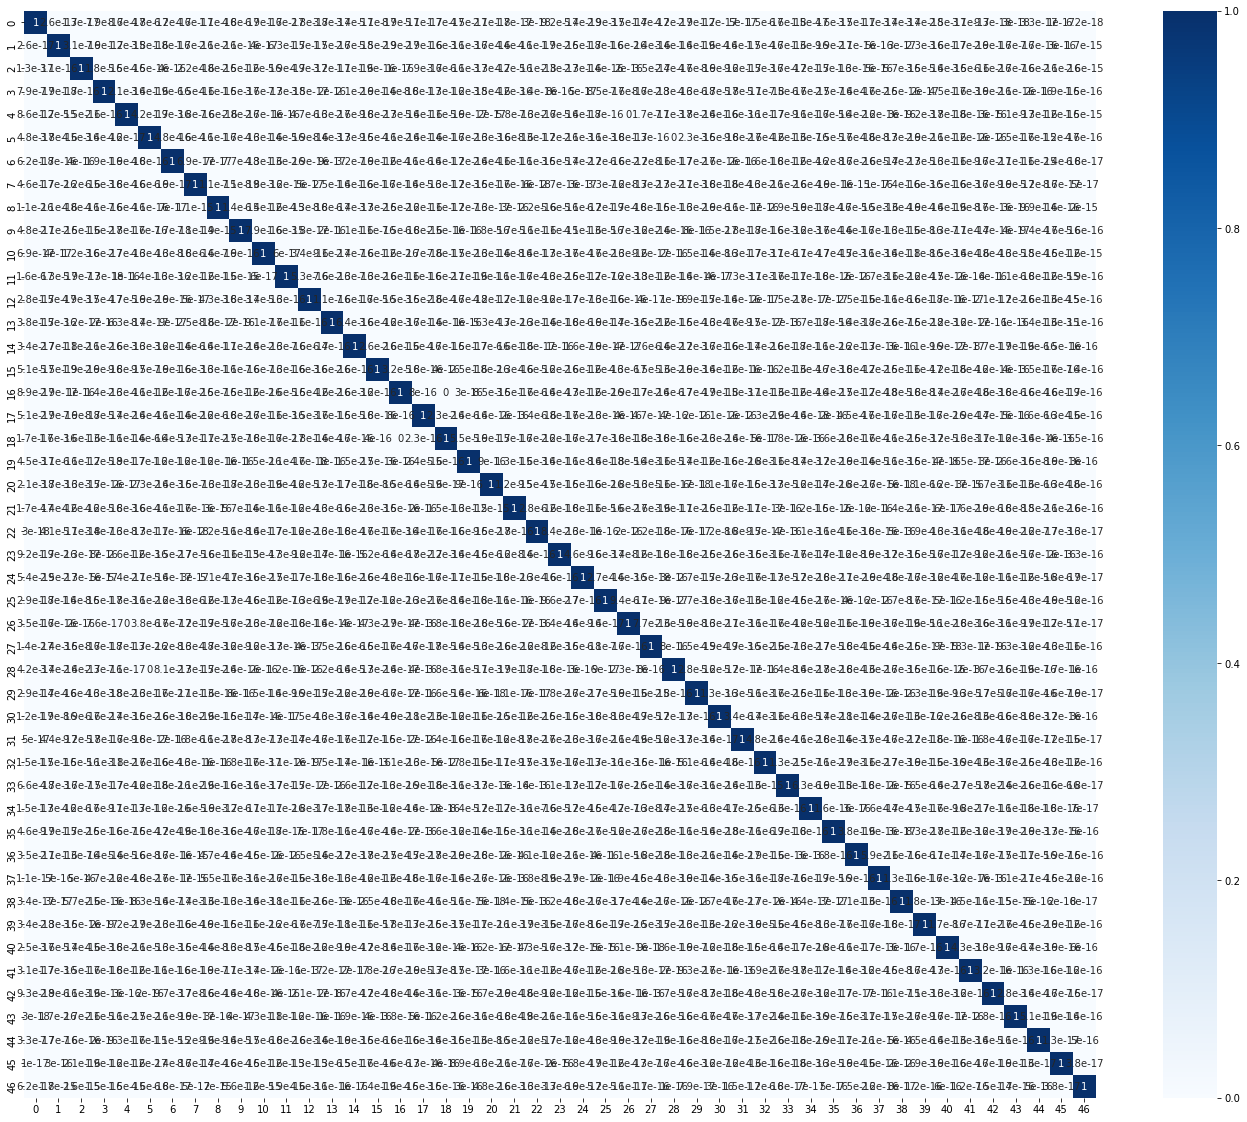

In [101]:
####Compute the correlation matrix after PCA
correlation_analysis = pd.DataFrame(X).corr().abs()
plt.figure(figsize = (24,20))
sns.heatmap(correlation_analysis, cmap="Blues", annot=True)
plt.show

#### No more correlation between different features after PCA
#### X is the transformed training dataset using PCA, it will have 45 features, 
#### with a total variance of the dataset of 99,78%

#     3 Supervised Data Analysis

### 3.1 Classifier Selection (DecisionTree, NaiveBayes, NN to be decided)

### 3.2 Cross-Validation

In [102]:
#### further split into training and validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    stratify = y, 
    train_size = 0.5/0.8, 
    random_state = 40
)

### Decision Tree

#### DecisionTree using GridSearchCV() function

In [103]:
parameters = {"criterion":['gini', 'entropy', 'log_loss'], 'max_depth':[None, 4, 6, 8, 10, 12, 14],
              'min_samples_split':[2, 3, 4, 5, 6, 7, 8]}

DT = DecisionTreeClassifier()
clf_DT = GridSearchCV(DT, parameters, cv = 20, scoring = 'precision')
clf_DT.fit(X_train, y_train)
print('Best Criterion:', clf_DT.best_estimator_.get_params()['criterion'])
print('Best max_depth:', clf_DT.best_estimator_.get_params()['max_depth'])
print('Best min_sample_split:', clf_DT.best_estimator_.get_params()['min_samples_split'])
print('Best Score:', clf_DT.best_score_)

Best Criterion: entropy
Best max_depth: None
Best min_sample_split: 6
Best Score: 0.7976630368012957


#### Decision Tree Manual GridSearch

In [104]:
#### Iterate over all possible combinations of hyperparameters for decisionTreeClassifier
best_combination = [0,1,2]
acc_max = 0
idx = -1
idx_best = idx
info_accuracy_train = []
info_accuracy_val = []

for criterion in ['gini', 'entropy', 'log_loss']:
    for max_depth in [None, 4, 6, 8, 10, 12, 14]:
        for min_samples_split in [2, 3, 4, 5, 6, 7, 8]:
            idx += 1

            random_states = set()
            while len(random_states) < 5:
                n = random.randint(0,1000000)
                random_states.add(n)
        
            accuraries_train_tmp = []
            accuraries_val_tmp = []
            
            #### Iterate over all random states with same training size to derive the 10 different performance
            for random_state in random_states:
                #### Further split into training and validation
                X_train_s, X_val_s, y_train, y_val = train_test_split(
                    X, y, 
                    stratify = y, 
                    train_size = 0.5/0.8, 
                    random_state = random_state
                )
                
                
                #### Initialize and fit a model per combination of parameters
                dt_tmp = DecisionTreeClassifier(
                    criterion = criterion, 
                    max_depth = max_depth, 
                    min_samples_split = min_samples_split,
                    random_state = 0
                )
                dt_tmp.fit(X_train_s, y_train)
                accuraries_train_tmp.append(accuracy_score(y_train, dt_tmp.predict(X_train_s)))
                accuraries_val_tmp.append(accuracy_score(y_val, dt_tmp.predict(X_val_s)))
        
            #### Calculate the statistics to generate overall performance
            accuraries_tmp = np.array(accuraries_train_tmp)
            mean_acc = accuraries_tmp.mean()
            min_acc = accuraries_tmp.min()
            max_acc = accuraries_tmp.max()
            info_accuracy_train.append((mean_acc, min_acc, max_acc))
            
            accuraries_tmp = np.array(accuraries_val_tmp)
            mean_acc = accuraries_tmp.mean()
            min_acc = accuraries_tmp.min()
            max_acc = accuraries_tmp.max()
            info_accuracy_val.append((mean_acc, min_acc, max_acc))

            if mean_acc >= acc_max:
                idx_best = idx
                acc_max = mean_acc
                best_combination[0] = criterion
                best_combination[1] = max_depth
                best_combination[2] = min_samples_split

print(
    f'Best criterion: {best_combination[0]}, ' + \
    f'Best max_depth: {best_combination[1]}, ' + \
    f'Best min_samples_split: {best_combination[2]}'
)
print(f'Best validation accuracy: {acc_max}')

Best criterion: gini, Best max_depth: 4, Best min_samples_split: 6
Best validation accuracy: 0.718


#### Plot manual GridSearch Decision Tree 

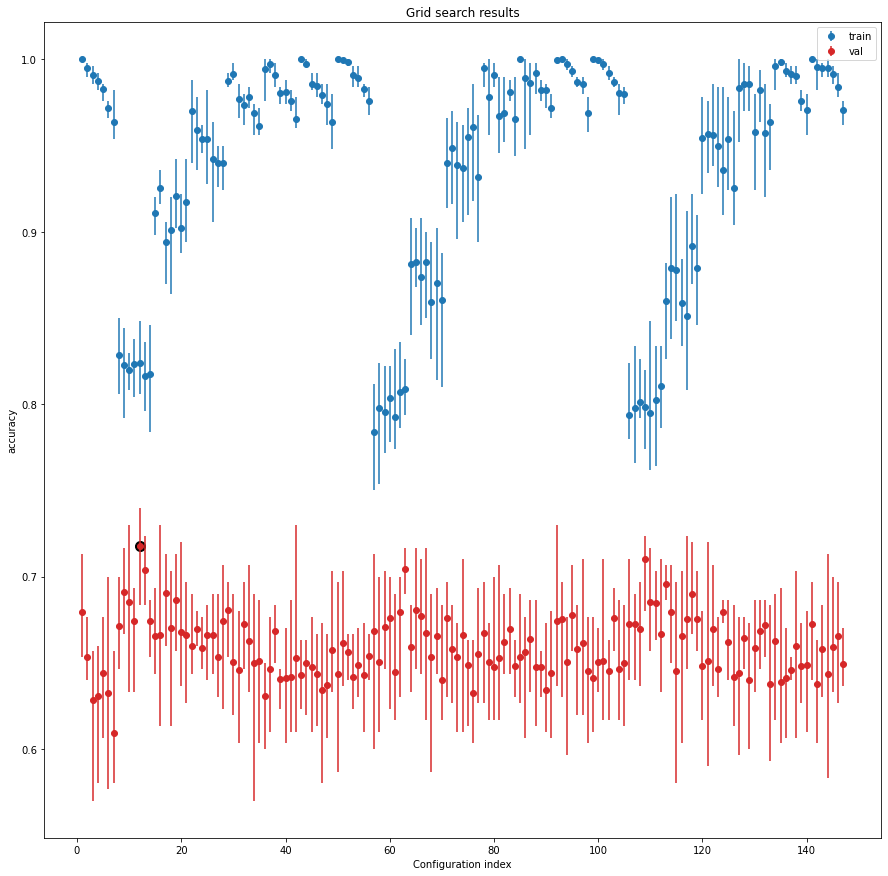

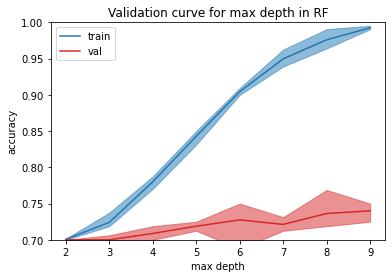

In [105]:
plt.figure(figsize=(15,15))

x = [i for i in range(1, len(info_accuracy_train)+1)]
plt.errorbar(x, [info_accuracy_train[i][0] for i in range(len(info_accuracy_train))],
             yerr=([info_accuracy_train[i][0]-info_accuracy_train[i][1] for i in range(len(info_accuracy_train))],[info_accuracy_train[i][2]-info_accuracy_train[i][0] for i in range(len(info_accuracy_train))]),
             marker='o',
             color='tab:blue', label='train',linestyle='')
plt.errorbar(x, [info_accuracy_val[i][0] for i in range(len(info_accuracy_val))],
             yerr=([info_accuracy_val[i][0]-info_accuracy_val[i][1] for i in range(len(info_accuracy_val))],[info_accuracy_val[i][2]-info_accuracy_val[i][0] for i in range(len(info_accuracy_val))]),
             marker='o',
             color='tab:red', label='val',linestyle='')
plt.title("Grid search results")
plt.xlabel('Configuration index')
plt.ylabel('accuracy')
plt.legend()

plt.scatter(idx_best+1, acc_max, marker='o', color='black',s=100)

plt.show()

### Gaussian Naive Bayes

#### GaussianNaiveBayes using GridSearchCV

In [106]:
parameters = {"var_smoothing":(np.logspace(-9,0,10))}

GNB = GaussianNB()
clf_GNB = GridSearchCV(GNB, parameters, cv = 20, scoring = 'precision')
clf_GNB.fit(X_train, y_train)
print('Best Var_Smoothing:', clf_GNB.best_estimator_.get_params()['var_smoothing'])
print('Best Score:', clf_GNB.best_score_)

Best Var_Smoothing: 0.001
Best Score: 0.7021678321678321


#### GaussianNaiveBayes using manual Grid Search

In [107]:
#### Iterate over all possible combinations for gaussianNaiveBayes
acc_max = 0
idx = -1
idx_best = idx
info_accuracy_train = []
info_accuracy_val = []

for var_smoothing in (np.logspace(-9,0,10)):
    idx += 1

    random_states = set()
    while len(random_states) < 5:
        n = random.randint(0,1000000)
        random_states.add(n)

    accuraries_train_tmp = []
    accuraries_val_tmp = []
    
    #### Iterate over all random states with same training size to derive the 10 different performance
    for random_state in random_states:
        #### Further split into training and validation
        X_train_s, X_val_s, y_train, y_val = train_test_split(
            X, y, 
            stratify = y, 
            train_size = 0.5/0.8, 
            random_state = random_state
        )
    
        #### Initialize and fit a model per combination of parameters
        gnb_tmp = GaussianNB()
        gnb_tmp.fit(X_train_s, y_train)
        accuraries_train_tmp.append(accuracy_score(y_train, gnb_tmp.predict(X_train_s)))
        accuraries_val_tmp.append(accuracy_score(y_val, gnb_tmp.predict(X_val_s)))
        
    #### Calculate the statistics to generate overall performance
    accuraries_tmp = np.array(accuraries_train_tmp)
    mean_acc = accuraries_tmp.mean()
    min_acc = accuraries_tmp.min()
    max_acc = accuraries_tmp.max()
    info_accuracy_train.append((mean_acc, min_acc, max_acc))
    
    accuraries_tmp = np.array(accuraries_val_tmp)
    mean_acc = accuraries_tmp.mean()
    min_acc = accuraries_tmp.min()
    max_acc = accuraries_tmp.max()
    info_accuracy_val.append((mean_acc, min_acc, max_acc))

    if mean_acc >= acc_max:
        idx_best = idx
        acc_max = mean_acc
        best = var_smoothing
        
print(f'Best var_smoothing: {best}')
print(f'Best validation accuracy: {acc_max}')

Best var_smoothing: 0.001
Best validation accuracy: 0.708


#### Plot manual GridSearch Gaussian Naive Bayes

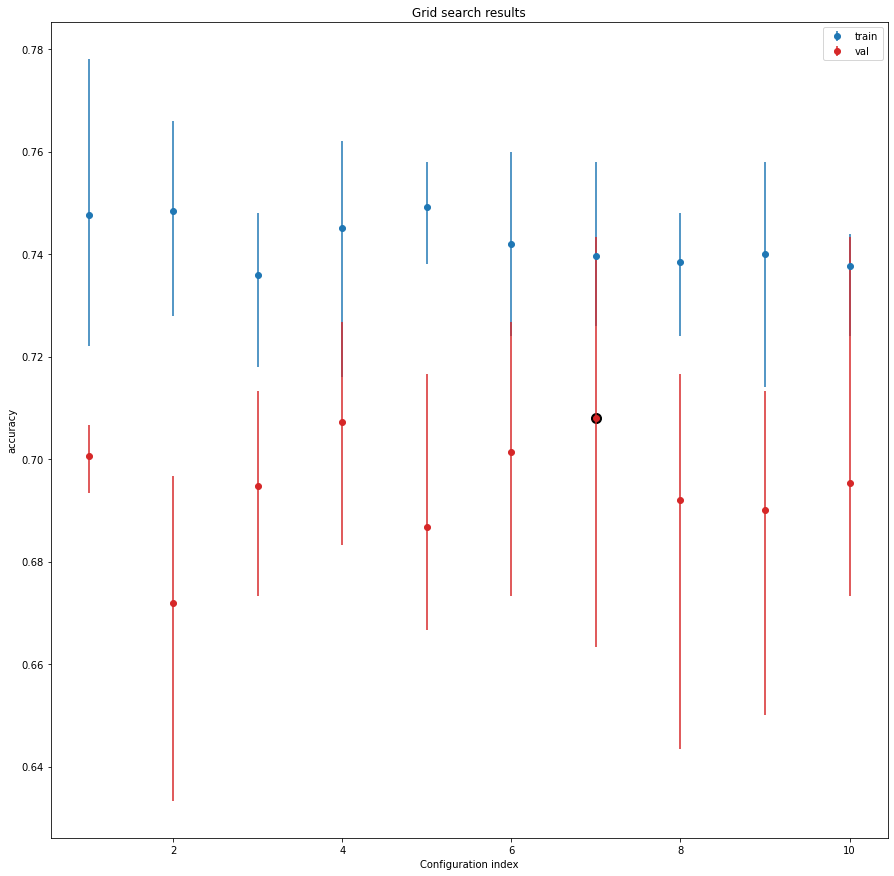

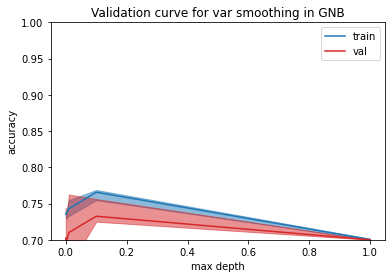

In [115]:
plt.figure(figsize=(15,15))

x = [i for i in range(1, len(info_accuracy_train)+1)]
plt.errorbar(x, [info_accuracy_train[i][0] for i in range(len(info_accuracy_train))],
             yerr=([info_accuracy_train[i][0]-info_accuracy_train[i][1] for i in range(len(info_accuracy_train))],[info_accuracy_train[i][2]-info_accuracy_train[i][0] for i in range(len(info_accuracy_train))]),
             marker='o',
             color='tab:blue', label='train',linestyle='')
plt.errorbar(x, [info_accuracy_val[i][0] for i in range(len(info_accuracy_val))],
             yerr=([info_accuracy_val[i][0]-info_accuracy_val[i][1] for i in range(len(info_accuracy_val))],[info_accuracy_val[i][2]-info_accuracy_val[i][0] for i in range(len(info_accuracy_val))]),
             marker='o',
             color='tab:red', label='val',linestyle='')
plt.title("Grid search results")
plt.xlabel('Configuration index')
plt.ylabel('accuracy')
plt.legend()

plt.scatter(idx_best+1, acc_max, marker='o', color='black',s=100)

plt.show()

acc_train_means = []
acc_train_maxs = []
acc_train_mins = []
acc_val_means = []
acc_val_maxs = []
acc_val_mins = []

for var_smoothing in np.logspace(-9,0,10):
    gnb_clf = GaussianNB(var_smoothing=var_smoothing)
    scores = cross_validate(gnb_clf, X, y, cv=5, scoring='accuracy', return_train_score=True)
    acc_train_means.append(scores['train_score'].mean())
    acc_train_maxs.append(scores['train_score'].max())
    acc_train_mins.append(scores['train_score'].min())
    acc_val_means.append(scores['test_score'].mean())
    acc_val_maxs.append(scores['test_score'].max())
    acc_val_mins.append(scores['test_score'].min())

plt.figure()
x = list(np.logspace(-9,0,10))
plt.plot(x, acc_train_means, color='tab:blue', label='train')
plt.fill_between(x, acc_train_mins, acc_train_maxs, alpha=0.5, color='tab:blue')
plt.plot(x, acc_val_means, color='tab:red', label='val')
plt.fill_between(x, acc_val_mins, acc_val_maxs, alpha=0.5, color='tab:red')
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.legend()
plt.title("Validation curve for var smoothing in GNB")
plt.ylim(0.7,1)
plt.show()

### 3.3 Classifier Evaluation

#### Decision Tree

              precision    recall  f1-score   support

         0.0       0.28      0.25      0.27        60
         1.0       0.69      0.73      0.71       140

    accuracy                           0.58       200
   macro avg       0.49      0.49      0.49       200
weighted avg       0.57      0.58      0.58       200



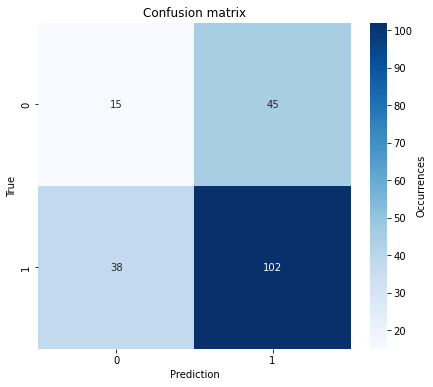

In [116]:
DT_final = DecisionTreeClassifier(
    criterion = clf_DT.best_estimator_.get_params()['criterion'], 
    max_depth = clf_DT.best_estimator_.get_params()['max_depth'], 
    min_samples_split = clf_DT.best_estimator_.get_params()['min_samples_split'],
    random_state = 0
)
DT_final.fit(X_train, y_train)
y_pred = DT_final.predict(X_test)

#### Classification report
print(classification_report(y_test, y_pred))

#### Get the confusion matrix of test set
confusion = confusion_matrix(y_test, y_pred)

#### Visualize the confusion matrix
plt.figure(figsize=(7,6))
sns.heatmap(confusion, cmap='Blues', annot=True, cbar_kws={'label':'Occurrences'}, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

#### Gaussian Naive Bayes

              precision    recall  f1-score   support

         0.0       0.40      0.27      0.32        60
         1.0       0.72      0.83      0.77       140

    accuracy                           0.66       200
   macro avg       0.56      0.55      0.55       200
weighted avg       0.63      0.66      0.64       200



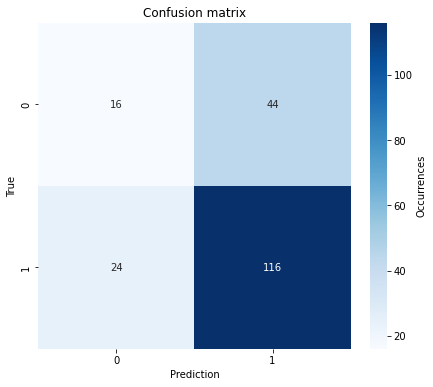

In [117]:
GNB_final = GaussianNB(
    var_smoothing = clf_GNB.best_estimator_.get_params()['var_smoothing'])
GNB_final.fit(X_train, y_train)
y_pred = GNB_final.predict(X_test)

#### Classification report

print(classification_report(y_test, y_pred))

#### Get the confusion matrix of test set
confusion = confusion_matrix(y_test, y_pred)

#### Visualize the confusion matrix
plt.figure(figsize=(7,6))
sns.heatmap(confusion, cmap='Blues', annot=True, cbar_kws={'label':'Occurrences'}, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()

# 4 Adversarial Attack #

### 4.1

In [ ]:
def add_noise_with_norm_clipping(data, norm_threshold):

    # Generate random noise with the same shape as the data
    noise = np.random.normal(size=data.shape)
    noise = pd.DataFrame(noise, columns=df_normalized.columns)
    display(noise)
    
    # Calculate the Euclidean norm of the noise
    noise_norm = np.linalg.norm(noise)
    
    # Clip the noise to have a certain Euclidean norm
    if noise_norm > norm_threshold:
        noise = noise * (norm_threshold / noise_norm)
    
    # Add noise to the data
    noisy_data = data + noise
    
    return noisy_data

# Specify the maximum Euclidean norm for the added noise
norm_threshold = 50

# Add noise to the data with Euclidean norm clipping
noisy_data = add_noise_with_norm_clipping(df_normalized, norm_threshold)

# Check the shape of the noisy dataset
print("Shape of noisy data:", noisy_data.shape)
display(df_normalized)
display(noisy_data)


### 4.2

### 4.3

### 4.4